<h1 style="color:blue"> Bayesian Statistics and Probabilistic Programming</h1>

<h1 style="color:blue"> Spring 2022 - Homework 01</h1>

<h2 style="color:blue"> Núria Camí, Ana de Garay and Claudia Herron</h1>

<h3 style="color:blue">2022-04-26</h3>

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exponential}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

<h1 style="color:blue">Instructions</h1>

### Submissions: 

By **groups** of _about_ three students (meaning: two is OK, four is not advisable but possible. Individual homeworks 
will also be accepted but collaborative work is preferable). 

Please send me an **email** with the team members names as soon as you have formed it.

Only **one copy** of each group's work must be uploaded (by any member)

### Format: 

A Jupyter or R Markdown **notebook,** with a **header** clearly stating the names of all contributors. 

### Documentation: 

Comments **in code cells** (e.g., meaning of variables, parameters, purpose of functions) are necessary but not sufficient.

You are expected to give full explanations of steps taken in your solution (in **Markdown cells**), as well as discussion of results and their meaning.

Do not drear being too verbose or too elementary.

### External sources

Getting inspiration from any book, document, blog, wep page, even mimicking solutions given in there, is **allowed and encouraged,** provided you give a **proper reference,**
understand every such material, and explain it in you own words, even more exhaustively.

Dare not **copy/paste literally.** I do detect it, believe me, even with a missing source reference. Bleak consequences.

### Deadline:

Completed assignments are due on Tuesday, April 19. They are to be uploaded to the Virtual Campus.

<h1 style="color:blue">01 - Stan version of a conjugate prior problem</h1>

<h2 style="color:blue">Modelling Earthquake Waiting Times</h2>

Consider the problem in `Exponential.02.Earthquake` (notebook in 2022-03-28 folder), where the goal is to study earthquake waiting times.

Likelihood is modelled as an $\expdist(\lambda)$ and $\lambda$ is given a conjugate prior, $\lambda\sim\gammadist(\alpha,\beta)$.

In this notebook some simulations are performed for:

01. Prior pdf for $\lambda$.
02. Prior predictive pdf for the waiting time.
03. Posterior pdf for $\lambda$.
04. Posterior predictive for new waiting time.

In `Exponential.02.Earthquake` we use known theoretical (analytical) descriptions of these distributions.

Your task is to redo these simulations using Stan, disregarding analytical conjugate prior formulas, and then comparing your results to the analytical ones. Use this comparison to tune up adjustable parameters in Stan sampling, such as chain length. 

## Solution:

First, we **load rstan** (the R interface to use Stan language) and set the recommended options.

In [1]:
require(rstan)
parallel::detectCores()
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



[1] 4

Now we can start doing the required simulations with its corresponding analysis.

### 1. Prior pdf for $\lambda$.

We know from the statement that $\lambda$ is given a conjugate prior, $\lambda\sim\gammadist(\alpha,\beta)$, where $\alpha > 0$ and $\beta > 0$ are unknown shape and scale parameters, respectively. Following the guidelines in ```S7.3.03.Exponential.02.Earthquake```, we see that $\alpha=1$ and $\beta=30$. This is due as a consecuence of setting the effective sample size to 1 and applying the formula for the expectation of a gamma distribution, given that E($\lambda$) is 1/30.

The Stan code simply draws samples from a gamma distribution, and we specify the parameters at runtime.

In [2]:
# Stan model to generate samples of a gamma distribution
Gamma_String <- "
    //functions {}
    data{
        real<lower=0> alpha;
        real<lower=0> beta;
        }
    transformed data {}
    parameters{}
    transformed parameters {}
    model{ }
    generated quantities{
        real y=gamma_rng(alpha,beta);
        }
"

# Translate the model to C++ and compile to DSO (Dynamic Shared Object)
Gamma_stanDso <- stan_model( model_code=Gamma_String ) 

Once that we have the DSO, we have to input the selected distribution parameters and Stan configuration to perform the simulation. Let's first take a look to the meaning of each parameter:
* **chains**	: A positive integer specifying the number of Markov chains. The default is 4.
* **algorithm**	: One of sampling algorithms that are implemented in Stan. No parameters in this scenario so we use "Fixed_param".
* **seed**	: The seed for random number generation.
* **iter**: A positive integer specifying the number of iterations for each chain (including warmup)
* **warmup**: A positive integer specifying the number of warmup (aka burnin) iterations per chain.
* **thin**: A positive integer specifying the period for saving samples. The default is 1, which is usually the recommended value.

In [3]:
# Specify data
prior.a<-1
prior.b<-30
Gamma_dataList <- list("alpha" = prior.a, "beta" = prior.b)

# Generate prior sample
GammaPrior_stanFit <- sampling( object=Gamma_stanDso, 
                     data = Gamma_dataList, algorithm="Fixed_param",
                     chains = 4, seed = 24056, iter = 10000, warmup = 0, thin = 1)

Finally,  we extract the prior sample and plot its histogram together with the theoretical gamma distribution.

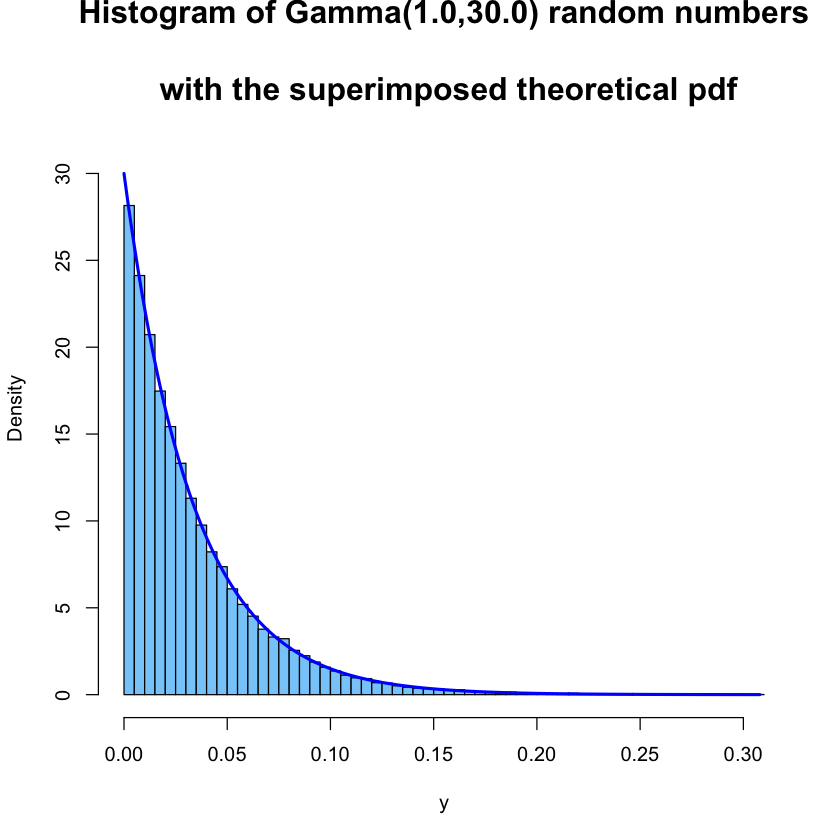

In [4]:
# Extract sample from the prior
y<-extract(GammaPrior_stanFit,par="y")$y
y.max<-max(y)
u<-seq(0,y.max,length=1000)

# Define the theoretical gamma distribution 
df.theor<-dgamma(u,shape=prior.a,rate=prior.b)
f.max<-max(df.theor)

# Histogram
hist(y,freq=FALSE,col="LightSkyBlue",ylim=c(0,f.max*1.1),
     main=sprintf("Histogram of Gamma(%2.1f,%2.1f) random numbers
    \n with the superimposed theoretical pdf",prior.a,prior.b),nclass=60,cex.main=1.6)
lines(u,df.theor,lwd=2.5,col="blue")

### 2. Prior predictive pdf for the waiting time.

The random variable that measures the waiting time (in days) between the 𝑖-th earthquake and the following one follows an Exponential distribution. That is:

$$
    Y_{i}\mskip8mu\text{i.i.d.}\sim\mskip8mu\operatorname{Exponential}(\lambda),
$$

where $\lambda$ is the conjugate prior described in the previous section. We also know that the expected waiting time between earthquakes will be $\operatorname{E}(Y)=1/\lambda$ days. 

Note that we can assume $Y_i$ as an independent and identically distributed random variable alluding at the premises taken at the beginning of the notebook ```S7.3.03.Exponential.02.Earthquake```.

The following cell shows the Stan model for the prior predictive pdf described here.

In [5]:
# Stan model to generate samples of an exponential distribution
Exp_Stancode <-"
    data{
        real<lower=0> alpha;
        real<lower=0> beta;
        }
    parameters {
        real lambda;   // parameter is an unbounded real (mean of observed xbar)
    }
    model {
        lambda ~ gamma(alpha,beta);   // prior
    }
    generated quantities {
        real y;
        y = exponential_rng(lambda);   // prior prediction
    }
"

# Translate the model to C++ and compile to DSO
Exp_stanDso <- stan_model( model_code=Exp_Stancode ) 

In [6]:
# Specify data
prior.a<-1
prior.b<-30
pppdf_dataList <- list("alpha" = prior.a, "beta" = prior.b)

# Generate prior sample
Exp_stanFit <- sampling( object=Exp_stanDso, 
                         data = pppdf_dataList,
                         chains = 1, 
                         seed = 24025, 
                         iter = 10000, 
                         warmup = 600, 
                         thin = 1)


SAMPLING FOR MODEL '29643737635e777a3c31106f98bf024a' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration:  601 / 10000 [  6%]  (Sampling)
Chain 1: Iteration: 1600 / 10000 [ 16%]  (Sampling)
Chain 1: Iteration: 2600 / 10000 [ 26%]  (Sampling)
Chain 1: Iteration: 3600 / 10000 [ 36%]  (Sampling)
Chain 1: Iteration: 4600 / 10000 [ 46%]  (Sampling)
Chain 1: Iteration: 5600 / 10000 [ 56%]  (Sampling)
Chain 1: Iteration: 6600 / 10000 [ 66%]  (Sampling)
Chain 1: Iteration: 7600 / 10000 [ 76%]  (Sampling)
Chain 1: Iteration: 8600 / 10000 [ 86%]  (Sampling)
Chain 1: Iteration: 9600 / 10000 [ 96%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.013686 seconds (Warm-up)
Chain 1:                0.288

Warning message:
“There were 4714 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [8]:
# Extract sample from the prior
y<-extract(Exp_stanFit,par="y")$y

# Quantiles
q.y<-quantile(y,c(0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
round(q.y,2)

# Maximum
ymax<-max(q.y)
round(ymax,2)

# Truncate in order to be able to plot the histogram
y.trunc<-y[y<ymax]  

5%    10%    20%    30%    40%    50%    60%    70%    80%    90% 
  1.57   3.34   7.39  12.86  20.24  30.11  44.50  68.78 116.91 282.79

[1] 282.79

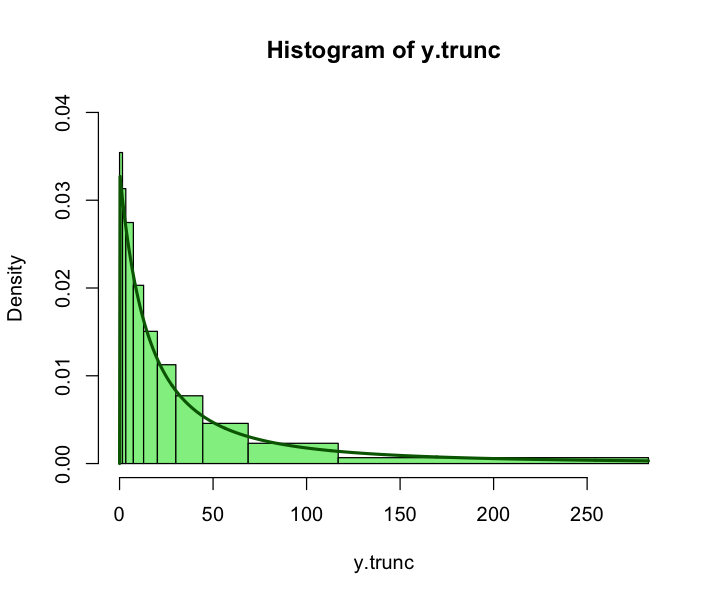

In [9]:
# Define the theoretical exponential distribution 
options(repr.plot.width=6,repr.plot.height=5)
Theor.pred.pdf<-function(y,a,b){return(ifelse(y>0,a*b^{a}/(y+b)^(a+1),0))}
ymax<-max(q.y)
u<-seq(0,ymax,length=1000)
yu<-Theor.pred.pdf(u,a=prior.a,b=prior.b)

# Histogram
hist(y.trunc,freq=FALSE,col="LightGreen", main=sprintf("Histogram of Exponential(lambda) random numbers
    \n with the superimposed theoretical pdf"), breaks=c(min(y.trunc),q.y,max(y.trunc)),ylim=c(0,0.040))
lines(u,yu,lwd=2.5,col="DarkGreen")

### 3. Posterior pdf for $\lambda$.

Once taking $n$ independent exponential observations of the experiment performed with the prior pdf described in section 2, then are able to define the posterior pdf for $\lambda$. At the end, the posterior distribution of $\lambda$ will be also a Gamma but with parameters $\alpha$ and $\beta$ updated. If we consider as $y=(y_{1},\dots,y_{n})$ the $n$ observations performed with average $\overline{y}$, then:

$$
    \left\{
    \begin{array}{lcl}
    \alpha'&=&\alpha+n,\\
    \beta'&=&\beta+n\,\overline{y},
    \end{array}\right.
$$

are the parameters for the Gamma distribution of the posterior pdf for $\lambda$.

In our example, we observed a total of 9 earthquake occurances. Thus, the number of time periods between earthquakes is $n=8$ and the data vector observed is $y=(16, 8, 114, 60, 4, 23, 30, 105)$, with $\overline{y}=45$.

In [10]:
# Data vector y observed
y<-c(16, 8, 114, 60, 4, 23, 30, 105)
n<-length(y)

# Mean of y
ybar<-mean(y)
round(ybar,2)

[1] 45

The updated parameters for the posterior pdf of $\lambda$ are:

In [11]:
# parameters of posterior pdf of lambda: alpha' and beta'
nybar<-sum(y)
post.a<-prior.a+n
post.b<-prior.b+nybar
post.a
post.b

[1] 9

[1] 390

In [12]:
# Measures of the posterior gamma distribution 

# mean 
Theor.lambda.post.mean<-post.a/post.b
round(Theor.lambda.post.mean,4)

# mode
Theor.lambda.post.mode<-(post.a-1)/post.b  # For alpha>1, 0 for alpha=1.
round(Theor.lambda.post.mode,4)

# variance
Theor.lambda.post.var<-post.a/post.b^2
round(Theor.lambda.post.var,6)

# std
Theor.lambda.post.sd<-sqrt(Theor.lambda.post.var)
round(Theor.lambda.post.sd,4)

[1] 0.0231

[1] 0.0205

[1] 5.9e-05

[1] 0.0077

In [13]:
# Specify data
Gamma_dataList <- list("alpha" = post.a, "beta" = post.b)

# Generate posterior sample
GammaPosterior_stanFit <- sampling( object=Gamma_stanDso, 
                     data = Gamma_dataList, algorithm="Fixed_param",
                     chains = 4, seed = 24056, iter = 10000, warmup = 0, thin = 1)

In [1]:
# Extract sample from the posterior
y<-extract(GammaPosterior_stanFit,par="y")$y
y.max<-max(y)
u<-seq(0,y.max,length=1000)

# Define the theoretical gamma distribution 
options(repr.plot.width=6,repr.plot.height=6)
v<-seq(0,max(y),length=1000)
yv<-dgamma(v,shape=post.a,rate=post.b)
max.yv<-max(yv)

# Histogram
hist(y,freq=FALSE,col="LightGreen", main=sprintf("Histogram of Gamma(%2.1f,%2.1f) random numbers
    \n with the superimposed theoretical pdf",prior.a,prior.b), xlab=expression(lambda),ylim=c(0,max.yv*1.1),breaks=25)
lines(v,yv,lwd=2.5,col="blue")

ERROR: Error in extract(GammaPosterior_stanFit, par = "y"): no se pudo encontrar la función "extract"


### 4. Posterior predictive pdf for the waiting time.

Finally, the posterior predictive pdf for the waiting time will behave like an Exp($\lambda$), where $\lambda$ is distributed as the posterior pdf described in the previous section.

In [ ]:
# Specify data:
pppdf_dataList <- list("alpha" = post.a, "beta" = post.b)

# Generate posterior sample
Exp_stanFit <- sampling( object=Exp_stanDso, 
                         data = pppdf_dataList,
                         chains = 1, 
                         seed = 24025, 
                         iter = 10000, 
                         warmup = 600, 
                         thin = 1)

In [ ]:
# Extract sample from the prior
y<-extract(Exp_stanFit,par="y")$y

# Quantiles
q.y<-quantile(y,c(0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
round(q.y,2)

# Maximum
ymax<-max(q.y)
round(ymax,2)

# Truncate in order to be able to plot the histogram
y.trunc<-y[y<ymax] 

In [ ]:
# Define the theoretical exponential distribution 
options(repr.plot.width=6,repr.plot.height=5)
Theor.pred.pdf<-function(y,a,b){return(ifelse(y>0,a*b^{a}/(y+b)^(a+1),0))}
ymax<-max(q.y)
u<-seq(0,ymax,length=1000)
yu<-Theor.pred.pdf(u,a=prior.a,b=prior.b)

# Histogram
hist(y.trunc,freq=FALSE,col="LightGreen", main=sprintf("Histogram of Exponential(lambda) random numbers
    \n with the superimposed theoretical pdf"), breaks=c(min(y.trunc),q.y,max(y.trunc)),ylim=c(0,0.040))
lines(u,yu,lwd=2.5,col="DarkGreen")

<h1 style="color:blue">02 - A more elaborate mixture prior for the spinning coin</h1>

(continued from Diaconis experiment)

On reflection, it was decided that tails had come up more often than heads in the past; further some coins seemed likely to be symmetric. 

Thus, a final approximation to the prior was taken as:

$$
   0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

Same observed data as in the previous model.

In [11]:
# Number of trials
n<-10
# Observed x
x.obs<-3

Perform a complete Bayesian analysis of this model, in close parallel to the first example.

(1) Using the theoretical formulas (prior predictive pmf, posterior pdf, posterior predictive pmf)

(2) Using independent random numbers (`rbeta()` functions, etc.)

(3) JAGS version

(4)$ {}^{\star}$ Stan version. 

>$ (\star)$ Hint: this one **is difficult** due to intrinsic limitations in Stan. There are several known workarounds; you can try to find one but do not despair if you fail to develop a workable version.

>As a matter of fact even a Stan version of the two-components prior mixture in `Mixture.priors.02.ipynb` 
is rather tricky: Stan does not allow integer parameters thus the JAGS code cannot be translated literally.

Diaconis and Ylvisaker (1985) compare both mixture conjugate priors with a $ \operatorname{Unif}(0,1)$ prior with the data above. 

Comparing the MAP estimators, they observe that in a first approximation, they coincide, but spreads do depend on the prior.

They repeat the computations above with a larger sample. 

In [11]:
n1<-50
x1.obs<-14

Their conclusion is that with small data, prior matters, but with larger samples, a finely tuned choice of prior is less important.

## Solution

The number of heads that we get in $n$ tosses of a spinning coin (likelihood function) behaves like a Binomial distribution:

$$
    x\mskip8mu\sim\mskip8mu\operatorname{B}(n,\theta),
$$

where $\theta$ is given a conjugate prior consisting of a mixture of three Beta distributions:

$$
   \theta\mskip8mu\sim0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

Note that since the conjugate prior of $\theta$ is in itself a bimodal function, it exhibits two local maxima. Recap that Beta distribution has two positive parameters $\alpha$ and $\beta$ that appear as exponents of the random variable and control the shape of the distribution.

First, let's see how this three Beta distributions look separately.

In [49]:
prior.a1<-10
prior.b1<-20
prior.a2<-15
prior.b2<-15
prior.a3<-20
prior.b3<-10
prior.gamma1<-0.5
prior.gamma2<-0.2

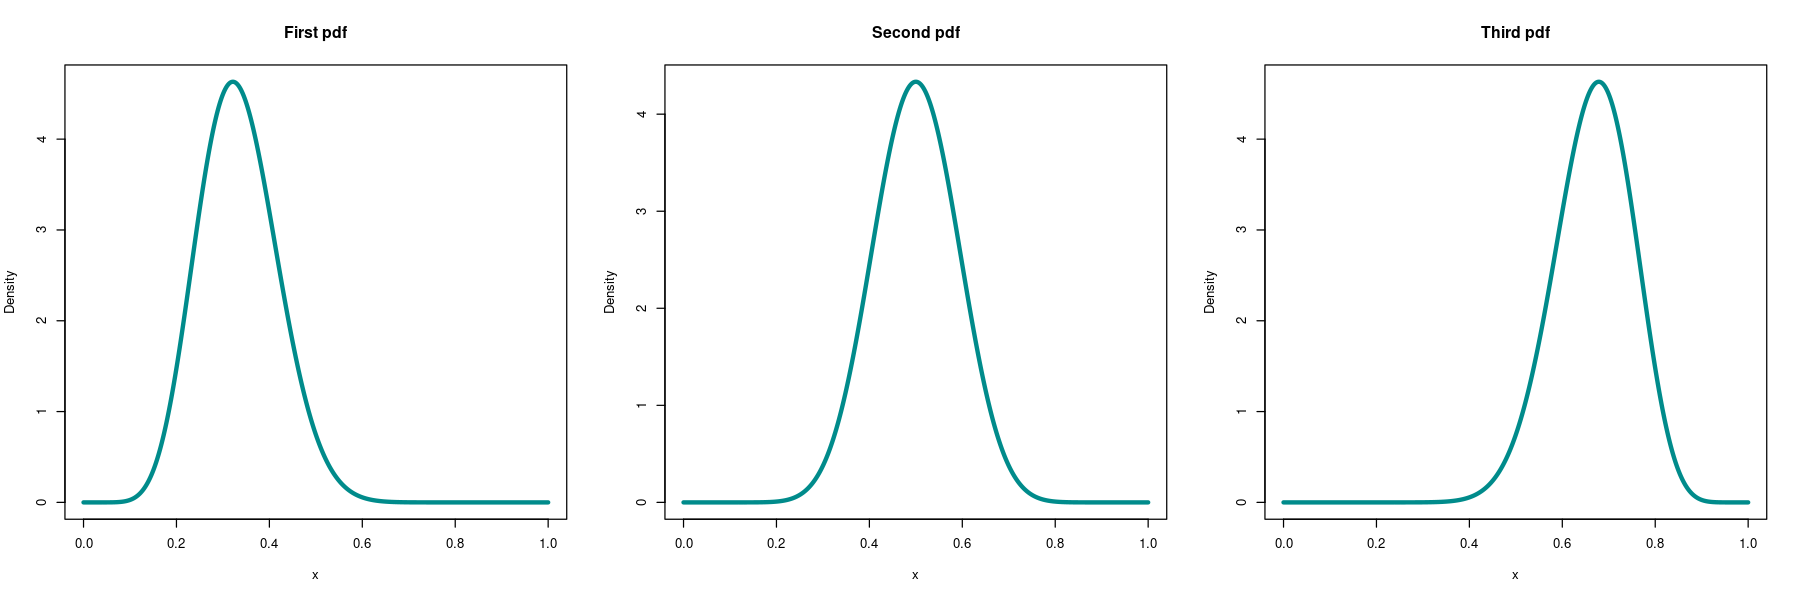

In [50]:
options(repr.plot.width=15,repr.plot.height=5)
v<-seq(0,1,length=500)
old.par<-par(mfrow=c(1,3))
plot(v,dbeta(v,prior.a1,prior.b1),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="First pdf")
plot(v,dbeta(v,prior.a2,prior.b2),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="Second pdf")
plot(v,dbeta(v,prior.a3,prior.b3),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="Third pdf")
par(old.par)

And the mixture prior:

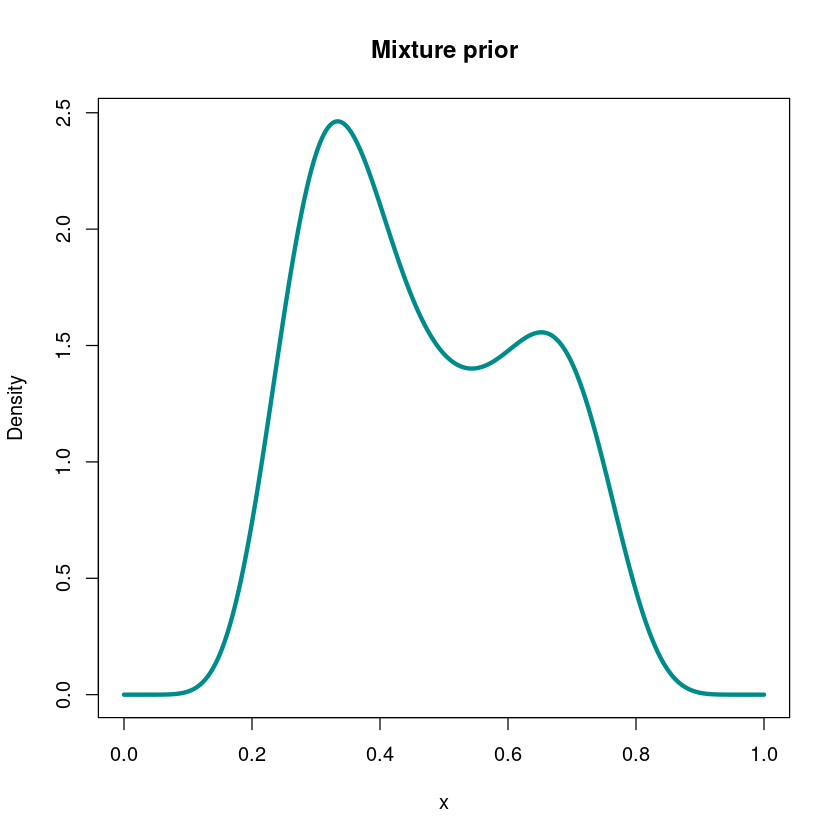

In [51]:
mixture.prior.pdf<-function(theta){
    return(prior.gamma1*dbeta(theta,prior.a1,prior.b1)+prior.gamma2*dbeta(theta,prior.a2,prior.b2)+(1-(prior.gamma1 + prior.gamma2))*dbeta(theta,prior.a3,prior.b3))
    }

options(repr.plot.width=7,repr.plot.height=7)
v<-seq(0,1,length=500)
plot(v,mixture.prior.pdf(v),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="Mixture prior")

We'll begin considering the same data as in the previous approach seen in class:

In [52]:
# Number of trials
n<-10
# Observed x
x.obs<-3

### 1. Using the theoretical formulas (prior predictive pmf, posterior pdf, posterior predictive pmf)

### 2. Using independent random numbers (rbeta() functions, etc.)

R programming language allows us to generate random distributed numbers with a set of built-in functions, such as runif(), rnorm(), rbinom(), etc. Therefore, thanks to them we can reformulate our $\theta$ parameter distribution by means of combining three rbeta(n, a, b) functions, where parameters a and b correspond to those giving shape to the distribution of each beta $\betadist(\alpha, \beta)$, and n is just the number of beta random numbers to generate, i.e., the size of the sample.

We stablish the nº of experiments to perform:

In [89]:
N<-20000

Next we generate a sample array in order to indicate from which beta distribution must we take the samples, where the probability of first beta is $0.5$, the probability of second distribution is $0.2$ and finally $0.3$ for the third beta distribution, as stated above in the definition of the mixture of betas distribution:

In [90]:
beta_sampling <- sample(c(1,2,3), #vector with elements from which to choose (indexes of our beta distributions)
                        replace = TRUE, #sampling with replacement
                        size = N, #sample size
                        prob=c(0.5, 0.2, 0.3) #vector of probability weights for obtaining the elements of the vector being sampled
                        )

Now we can reproduce a sample $\theta$'s array by random sampling from our three beta distributions according to the previously defined vector:

In [91]:

theta <- c(rbeta(N, prior.a1, prior.b1)[beta_sampling == 1], 
           rbeta(N, prior.a2, prior.b2)[beta_sampling == 2], 
           rbeta(N, prior.a3, prior.b3)[beta_sampling == 3])

And therefore the histogram of our simulated prior will be:

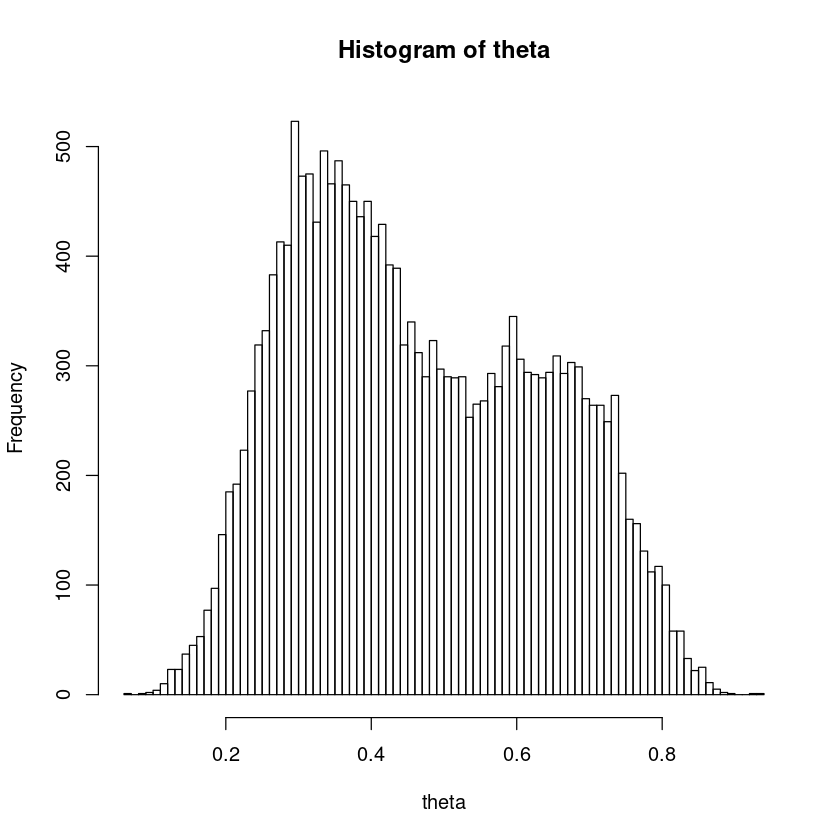

In [92]:
hist(theta, breaks=100)

That is in fact consistent with our previous mixture prior plot. 

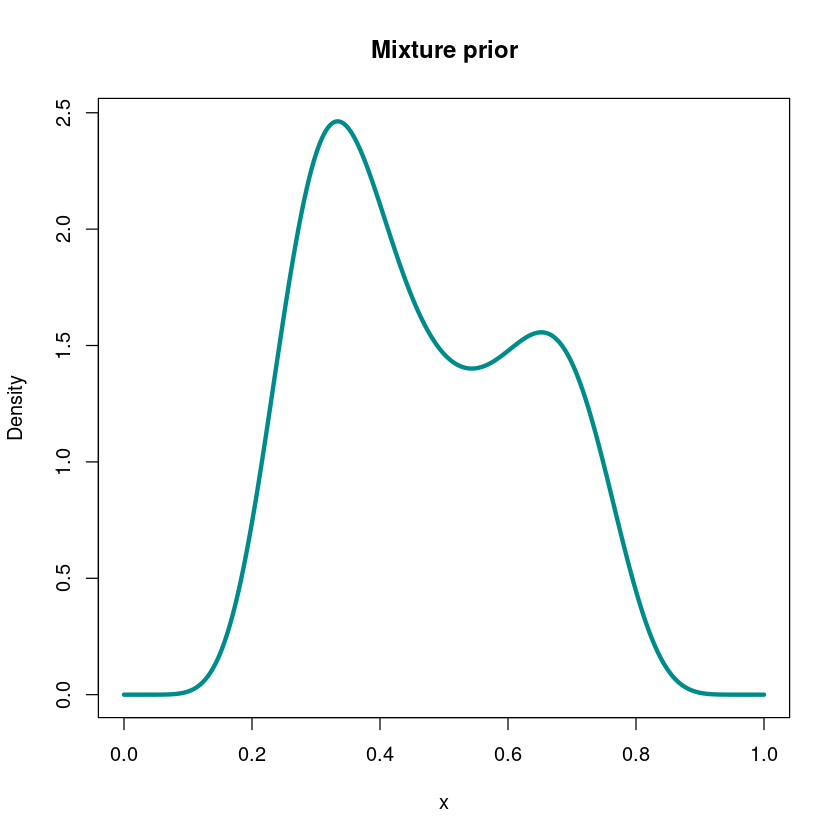

In [93]:
plot(v,mixture.prior.pdf(v),type="l",lwd=3.5,col="cyan4",xlab="x",ylab="Density",main="Mixture prior")

Once we have our $\theta$ sample we are able to reproduce the binomial behaviour of the flipping coin by means of the rbinom(n, size, prob) function, whichs models the number of heads in N experiments (n parameter); the size parameter is the number of distinct attempts, and prob is the probability of success (i.e., of head) on each trial, which in our case comes given by the previously extracted theta sampling vector.

In [94]:
heads <- rbinom(n = N, size = n , prob = theta)

The relative frequencies obtained for each possible number of heads in our 10 trials are then

In [95]:
pmf <- table(heads)/sum(table(heads))
pmf

heads
      0       1       2       3       4       5       6       7       8       9 
0.01605 0.06210 0.10805 0.14665 0.15880 0.15310 0.13070 0.10795 0.07180 0.03515 
     10 
0.00965 

And therefore we can represent its prior predictive probability mass function as 

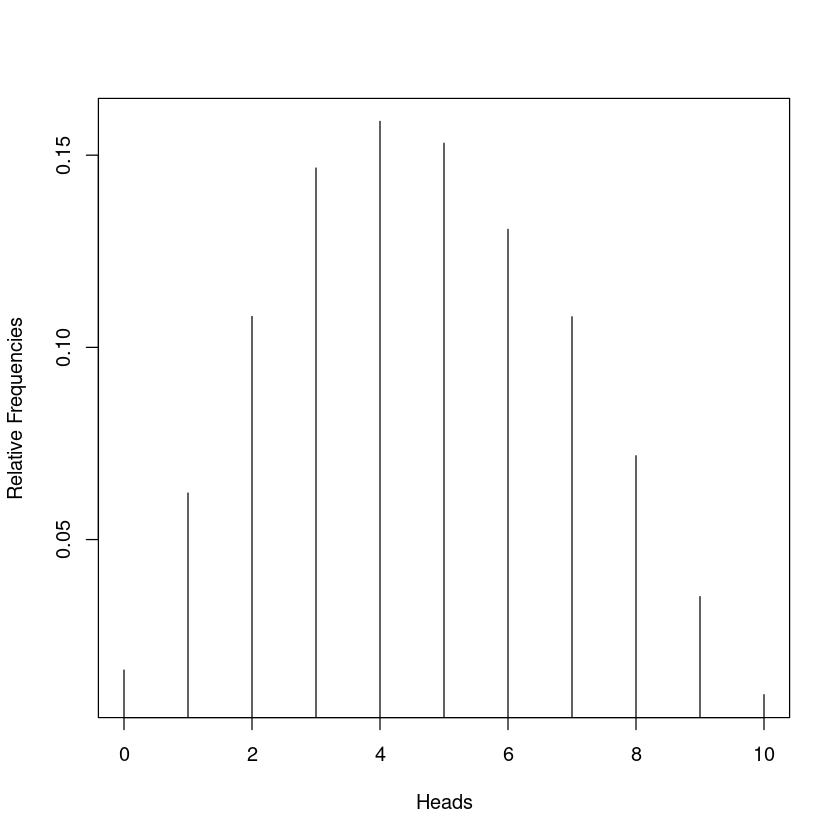

In [96]:
matplot(x=names(pmf),y=pmf, type ='h',
        xlab="Heads",ylab="Relative Frequencies")


So the probability of obtaining x=3 heads would be:

In [97]:
pmf[x.obs + 1]

3 
0.14665

Therefore we can seletect those thetas that produce x=3, i.e.,

In [98]:
t_3heads <- theta[heads == 3]

Whose histogram would be:

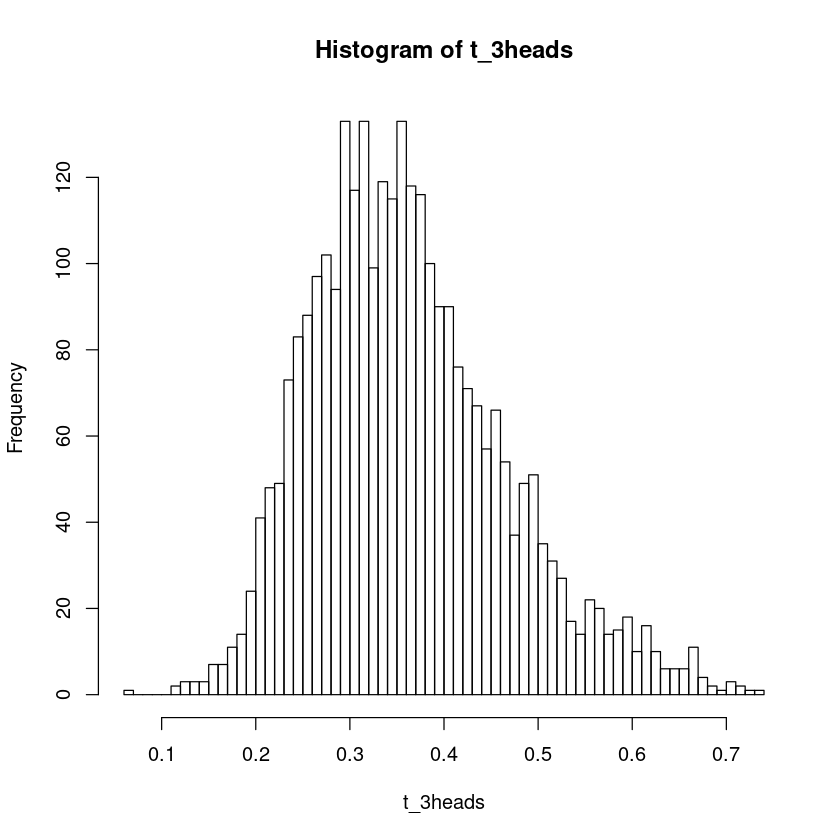

In [104]:
hist(t_3heads, breaks=50)

Now we can simulate the partial posteriors probability density function for each of the three beta distributions modeling the behaviour of the theta parameter, considering x=3:

In [100]:
posterior.a1<-prior.a1+x.obs
posterior.b1<-prior.b1+n-x.obs
posterior.a2<-prior.a2+x.obs
posterior.b2<-prior.b2+n-x.obs
posterior.a3<-prior.a3+x.obs
posterior.b3<-prior.b3+n-x.obs

In [101]:
sprintf("Posterior parameters for the first component: (%2.0d,%2.0d)",posterior.a1,posterior.b1)
sprintf("Posterior parameters for the second component: (%2.0d,%2.0d)",posterior.a2,posterior.b2)
sprintf("Posterior parameters for the third component: (%2.0d,%2.0d)",posterior.a3,posterior.b3)

[1] "Posterior parameters for the first component: (13,27)"

[1] "Posterior parameters for the second component: (18,22)"

[1] "Posterior parameters for the third component: (23,17)"

And following the same reasoning as above, we can obtain the simulated posterior for $\theta$:

In [102]:
theta.pos <- c(rbeta(N, posterior.a1, posterior.b1)[beta_sampling == 1], 
               rbeta(N, posterior.a2, posterior.b2)[beta_sampling == 2], 
               rbeta(N, posterior.a3, posterior.b3)[beta_sampling == 3])

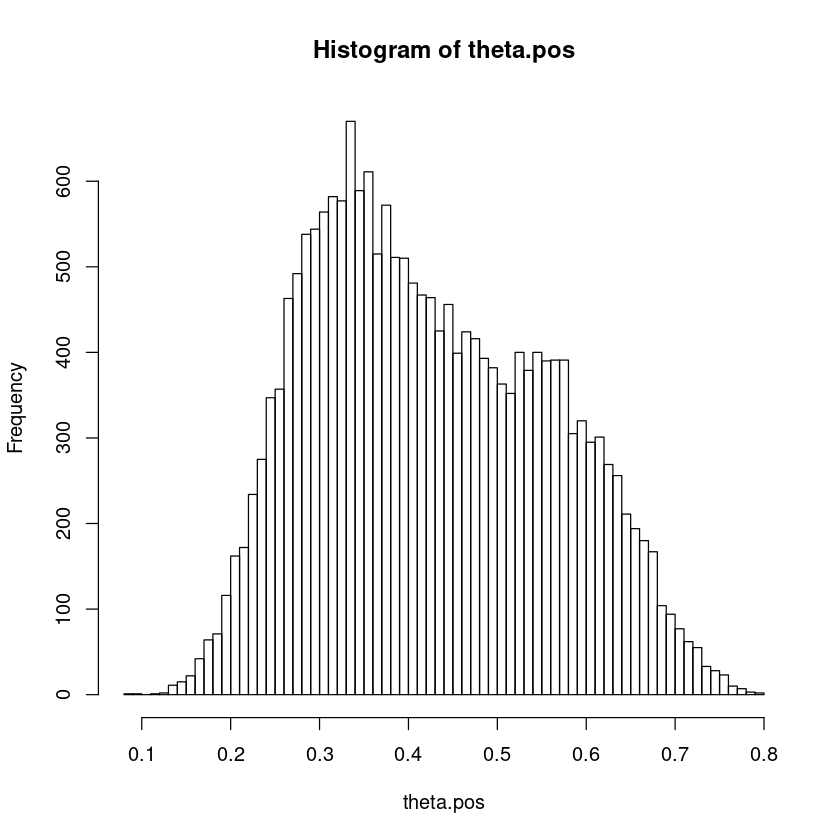

In [103]:
hist(theta.pos, breaks=100)

And therefore the simulated posterior of the experiment would be:

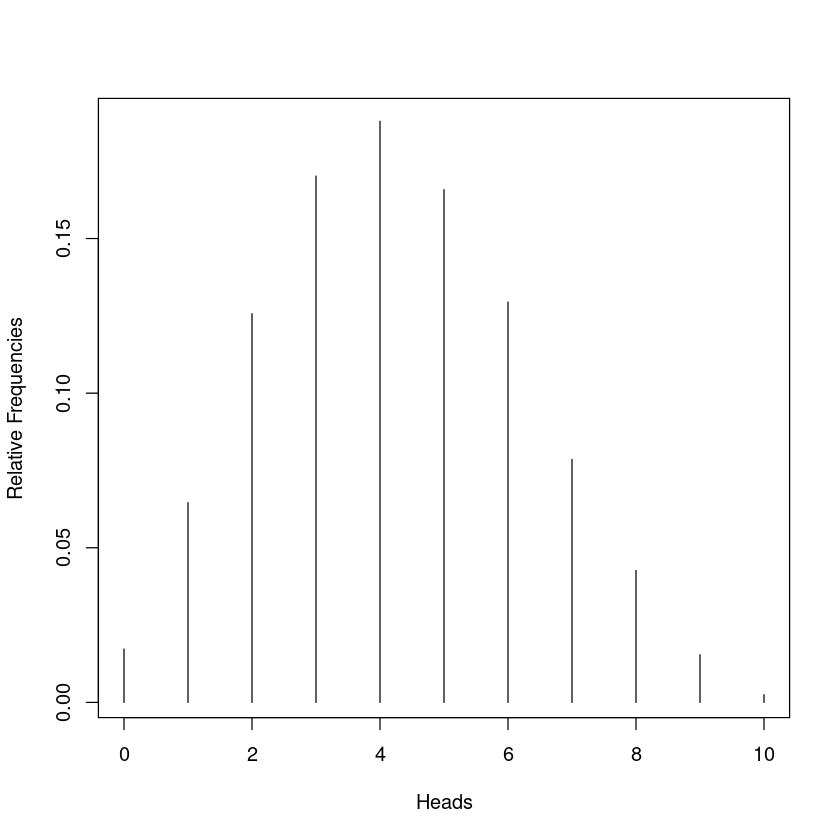

In [105]:
heads <- rbinom(n = N, size = n , prob = theta.pos)

pmf <- table(heads)/sum(table(heads))

matplot(x=names(pmf),y=pmf, type ='h',
        xlab="Heads",ylab="Relative Frequencies")


### 3. JAGS version

First we load JAGS

In [16]:
require(R2jags)

Loading required package: R2jags

Loading required package: rjags

Loading required package: coda


Attaching package: ‘coda’


The following object is masked from ‘package:rstan’:

    traceplot


Error: package or namespace load failed for ‘rjags’:
 .onLoad failed in loadNamespace() for 'rjags', details:
  call: dyn.load(file, DLLpath = DLLpath, ...)
  error: unable to load shared object '/Library/Frameworks/R.framework/Versions/4.1/Resources/library/rjags/libs/rjags.so':
  dlopen(/Library/Frameworks/R.framework/Versions/4.1/Resources/library/rjags/libs/rjags.so, 10): Library not loaded: /usr/local/lib/libjags.4.dylib
  Referenced from: /Library/Frameworks/R.framework/Versions/4.1/Resources/library/rjags/libs/rjags.so
  Reason: image not found



Define parameters of the model

In [17]:
Mix.01.dat<-list(a1=prior.a1,b1=prior.b1,
                 a2=prior.a2,b2=prior.b2,
                 a3=prior.a3,b3=prior.b3,
                 gamma1=prior.gamma1,
                 gamma2=prior.gamma2,
                 n=n,x=x.obs)

Build the model

In [18]:
cat(
"model
    {
    x~dbin(p,n)             # Binomial likelihood. See arguments order!
    
    p<-theta[r]             # Prior is a mixture of three beta r.v 
                            # Notice the syntax: this statement says that p is
                            # *equal to* the trio of theta variates defined below

    r~dcat(g[])             # Categorical distribution:
                            # g[] is a 3-vector containing the mixing probabilities (gamma1, gamma2, 1-(gamma1 + gamma2))

    theta[1]~dbeta(a1,b1)   # The three beta r.v to enter the mixture
    theta[2]~dbeta(a2,b2)
    theta[3]~dbeta(a3,b3)

    g[1]<-gamma1             # Just as in p. g is equal to (gamma1, gamma2, 1-(gamma1 + gamma2))
    g[2]<-gamma2
    g[3]<-1-(gamma1 + gamma2)
    }"
    ,file="Mix.01.jag")

Now let's run JAGS

In [19]:
#### set the parameters n.chains,n.iter,n.burnin as we wish

In [20]:
Mix.01.m1<-jags(data=Mix.01.dat, n.chains=3,n.iter=5000,n.burnin=500, 
        parameters.to.save=c("theta","p"), model.file="Mix.01.jag")

ERROR: Error in jags(data = Mix.01.dat, n.chains = 3, n.iter = 5000, n.burnin = 500, : could not find function "jags"


In [ ]:
print(Mix.01.m1)

Posterior pdf of p

In [ ]:
p.sample<-Mix.01.m1$BUGSoutput$sims.list$p

In [ ]:
p.sample.density<-density(p.sample)
plot(p.sample.density,lwd=2.5,col="blue",main=expression(paste("Estimated posterior pdf of ",p)),cex.main=1.6)

### 4. Stan version

### Bibliography

http://www.scielo.org.co/pdf/rce/v36n2/v36n2a09.pdf

https://news.stanford.edu/pr/2004/diaconis-69.html

"Dynamical Bias in the Coin Toss"

https://chrispiech.github.io/probabilityForComputerScientists/en/part4/beta/